# Focusing on the North Celestial Pole Loop (NCPL)

________________________________________________________________________________________________________________________

## Import all python libraries

Here, I am importing all python libraries I will be using

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from ROHSApy import ROHSA
from scipy.optimize import curve_fit
import random
from scipy.stats import norm

# For the mosaic of the maps
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter

## Download the cube data

The first thing I need to do is download the data cube. I went to the address: https://www.cita.utoronto.ca/GHIGLS/ to download the data cube. The designated region I am working with is the SPIDER region. 

In [2]:
#!wget https://www.cita.utoronto.ca/GHIGLS/FITS/GHIGLS_SPIDER_Tb.fits

I am also installing ROHSApy.

In [3]:
#!pip install ROHSApy

## Load the data cube

inpainted cube (new cube)

In [4]:
# Now I need to load the data cube that I collected in the above step.
fitsname = "GHIGLS_NCPL_Tb_INPAINTED_SUBCUBE.fits"
hdu = fits.open(fitsname)
hdr = hdu[0].header
cube = hdu[0].data[:,:,:]
# In the PPV cube, there are 3 axes (Representing the three spaces in the list).
# The first is the velocity axis. The others represent the position coordinates, x and y.
cube.shape

(654, 256, 256)

In [5]:
cube[cube != cube] = 0

In order to get the axis to be in units of velocity, need this function which converts pixel units to velocity (km/s)

In [6]:
def spec_2_velocity(CRVAL, CDELT, CRPIX, index):
    '''
    Description: 
        This function takes in the parameters from the header and adjusts the \
        velocity range so that is centers at zero (based on the reference). 
    
    Parameters:
        CRVAL - The value of the reference velocity - float
        CDELT - The value of the channel spacing - float
        CRPIX - The value of the pixel where CRVAL occurs - float
    
    Returns:
        This function returns the adjusted velocity list - list
    '''
    vel = [(CRVAL + CDELT * (index[i] - CRPIX)) for i in range(len(index))]
    # Puts in units of km/s
    
    return vel

Need to adjust the header for the axis to have correct units. I can define where I want my cuts in velocity and/or in the x and y axes, then subtract from the original header.

In [7]:
idx_lim_left = 225; idx_lim_right = 375

In [8]:
hdr["NAXIS3"] = idx_lim_right-idx_lim_left # The range of subvel (end_subvel - start_subvel)
hdr["CRPIX3"] -= idx_lim_left # This is to fix the position of the peaks to have the right index and velocity

In [9]:
index_arr = np.arange(cube.shape[0])

cdelt3 = hdr["CDELT3"]/1000. #This allows it to be in units of km/s rather than m/s
crpix3 = hdr["CRPIX3"]
crval3 = hdr["CRVAL3"]/1000. #This allows it to be in units of km/s rather than m/s

vel = np.array(spec_2_velocity(crval3,cdelt3,crpix3,index_arr))

## Function for producing Gaussians

Here, I define a function for a gaussian function. I will be plotting some gaussians manually, so I need this function for later

In [10]:
# Some constants for the integrals:
dv = abs(cdelt3)
C = 1.82243e18

In [13]:
# Function for a single Gaussian 
def one_gauss_func(x, amp, cent, sigma):
    '''
    Description: 
        Evaluates a Gaussian function given some parameters
    
    Parameters:
        x - Value at which the Gaussian is evaluated at - float
        amp - The amplitude of the Gaussian - float
        cent - The location of the of the peak - float 
        sigma - The width of the peak - float
    
    Returns:
        The function evaluated at each x - 1D array
    '''
    return amp*np.exp(-((x-cent)/(2*sigma))**2)

def func(x, *params):
    '''
    Description: 
        Evaluates a Gaussian function given some parameters
    
    Parameters:
        x - Value at which the Gaussian is evaluated at - float
        params - params[0::3] (amp) - The amplitude of the Gaussian - float
               - params[1::3] (cent) - The location of the of the peak - float 
               - params[2::3] (sigma) - The width of the peak - float
    
    Returns:
        The function evaluated at each x - 1D array
    '''
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        c = params[i+1]
        s = params[i+2]
        y = y + a * np.exp( -((x - c)/(2*s))**2)
    return y

## Define the limits and the region

In [14]:
subvel = vel[:idx_lim_right-idx_lim_left]
subcube = cube[idx_lim_left:idx_lim_right, :, :] # Want the whole spider, so full x and y axes

I can first just plot a random spectrum, then also plot the average spectrum, which will give us more information

x =  101  y =  136


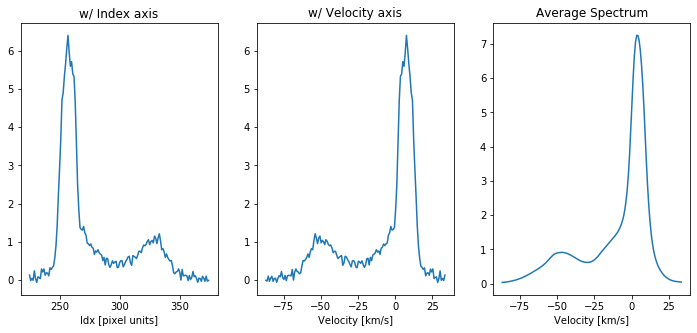

In [15]:
x_rand = random.randint(0,255) ; y_rand = random.randint(0,255)
print('x = ',x_rand,' y = ',y_rand)

avg = np.mean(subcube, (1,2))

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.title("w/ Index axis"); plt.xlabel("Idx [pixel units]")
plt.plot(index_arr[idx_lim_left:idx_lim_right], subcube[:,y_rand, x_rand])

plt.subplot(1,3,2)
plt.title("w/ Velocity axis"); plt.xlabel("Velocity [km/s]")
plt.plot(subvel, subcube[:,y_rand, x_rand])

plt.subplot(1,3,3)
plt.title("Average Spectrum"); plt.xlabel("Velocity [km/s]")
plt.plot(subvel, avg)

plt.show()

## Noise Map

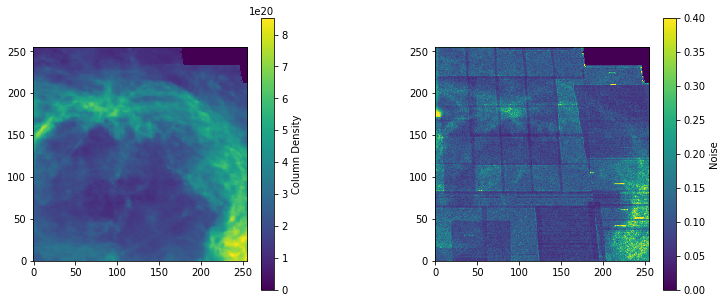

In [16]:
plt.figure(figsize=(12,5))
noise_cube = cube[:24] # Using the first 24 channels of the index axis.
noise_map = np.std(noise_cube, 0)

rms = np.array([noise_map*(1+channel/20) for channel in subcube]) # channel means T_b

plt.subplot(1,2,1)
plt.imshow(np.sum(subcube, 0)*C*dv, origin='lower') ; plt.colorbar(label="Column Density")
plt.subplot(1,2,2)
plt.imshow(rms[37], origin='lower', vmin=0, vmax=0.4) ; plt.colorbar(label='Noise')
plt.subplots_adjust(wspace=0.5)

## Obtain the Gaussian parameters for the decompositions

In [17]:
core = ROHSA(subcube, hdr=hdr)

I will let "A" represent the decomposition corresponding to the 40 Gaussians (lambdas = 0, varsig = 0)

In [18]:
gaussian_A = core.read_gaussian("GHIGLS_NCPL_Tb_gauss_run_0_0_Noise3D_40G.dat")
params_A = core.physical_gaussian(gaussian_A)
n_gauss_A = 40

print("dim cube = " + str(gaussian_A.shape))

model_A = core.return_result_cube(gaussian=gaussian_A)

# Physical Space
amplitude_A = gaussian_A[0::3]
position_A = np.array(spec_2_velocity(crval3,cdelt3,crpix3,gaussian_A[1::3]))
dispersion_A = gaussian_A[2::3]

# "Pixel" Space
amplitude_pix_A = gaussian_A[0::3]
position_pix_A = gaussian_A[1::3]
dispersion_pix_A = gaussian_A[2::3]* dv

integral_A = amplitude_A * dispersion_A * np.sqrt(2*np.pi) 
NHI_map_A = integral_A * C * dv

Opening data file
dim cube = (120, 256, 256)


I will let "B" represent the decomposition corresponding to the 48 Gaussians (lambdas = 0, varsig = 0)

In [19]:
gaussian_B = core.read_gaussian("GHIGLS_NCPL_Tb_gauss_run_0_0_Noise3D_48G.dat")
params_B = core.physical_gaussian(gaussian_B)
n_gauss_B = 48

print("dim cube = " + str(gaussian_B.shape))

model_B = core.return_result_cube(gaussian=gaussian_B)

# Physical Space
amplitude_B = gaussian_B[0::3]
position_B = np.array(spec_2_velocity(crval3,cdelt3,crpix3,gaussian_B[1::3]))
dispersion_B = gaussian_B[2::3]

# "Pixel" Space
amplitude_pix_B = gaussian_B[0::3]
position_pix_B = gaussian_B[1::3]
dispersion_pix_B = gaussian_B[2::3]* dv

integral_B = amplitude_B * dispersion_B * np.sqrt(2*np.pi) 
NHI_map_B = integral_B * C * dv

Opening data file
dim cube = (144, 256, 256)


## Plot a Spectrum

Now, I want to plot a random spectrum / pixel in this region

In [20]:
def plot_spect(n_gauss, x_pos, y_pos, vel, model, cube, gaussian, model2="None", caption=""):
    #fig = plt.figure(figsize=(8,6))
    plt.xlabel("$v$ [$km$ $s^{-1}$]")
    plt.ylabel("$T_{b}$ [$K$]")
    plt.plot(vel, cube, color='cornflowerblue',  label="data")
    plt.plot(vel, model , 'r', label="model (pix by pix)")
    if model2 != "None":
        plt.plot(vel, model2 , 'g', label="model (comp by comp)")
    
    # To plot all the gaussians under the model and data:
    for i in range(n_gauss):
            plt.plot(vel, core.gauss(np.arange(len(vel)), \
                                              gaussian[0::3][i][y_pos,x_pos],\
                                              gaussian[1::3][i][y_pos,x_pos],\
                                              gaussian[2::3][i][y_pos,x_pos]), 'k')
    plt.legend()
    #plt.show()
    #fig.savefig(caption, bbox_inches="tight")

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper right')

def plot_spect_color(x, y, v, model, cube, gaussian, caption=""):
    fig = plt.figure(figsize=(12,6.5))
    ax = fig.add_subplot(111)
    ax.set_xlabel("v [$km$ $s^{-1}$]")
    ax.set_ylabel("T$_{b}$ [$K$]")
    ax.plot(v, cube, color='green',  label="data")
    ax.plot(v, model, color='black', label="model")
    
    # To plot all the gaussians under the model and data:
    for i in range(n_gauss):
        gauss = core.gauss(np.arange(len(v)), gaussian[0::3][i][y,x], gaussian[1::3][i][y,x], gaussian[2::3][i][y,x])
        if gaussian[2::3][i][y,x] < 3.:
            ax.plot(v, gauss, color='deepskyblue', label="CNM")
            #ax.fill_between(v, gauss.min(), gauss, facecolor="____", alpha=0.2)
        if gaussian[2::3][i][y,x] >=3. and gaussian[2::3][i][y,x] < 6.:
            ax.plot(v, gauss, color='darkorchid', label="UNM")
            #ax.fill_between(v, gauss.min(), gauss, facecolor="____", alpha=0.2)
        if gaussian[2::3][i][y,x] >= 6.:
            ax.plot(v, gauss, color='red', label="WNM")
            #ax.fill_between(v, gauss.min(), gauss, facecolor="____, alpha=0.2)
            
    legend_without_duplicate_labels(ax)
    plt.show()
    #fig.savefig(caption, bbox_inches="tight")

x =  6
y =  168


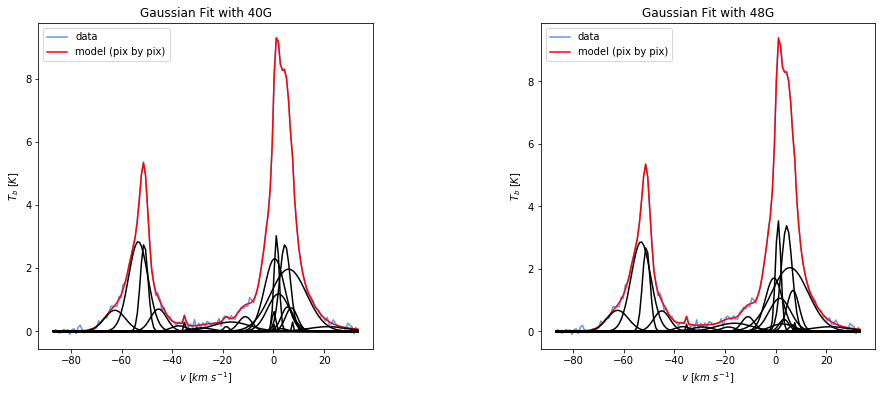

In [23]:
x_pos = random.randint(0,168)
y_pos = random.randint(0,168)
print("x = ", x_pos) ; print("y = ", y_pos)
plt.figure(figsize=(15,6))
plt.subplot(1,2,1) ; plt.title("Gaussian Fit with "+str(n_gauss_A)+"G")
plot_spect(n_gauss_A, x_pos, y_pos, subvel, model_A[:, y_pos, x_pos], subcube[:, y_pos, x_pos], gaussian_A)
plt.subplot(1,2,2) ; plt.title("Gaussian Fit with "+str(n_gauss_B)+"G")
plot_spect(n_gauss_B, x_pos, y_pos, subvel, model_B[:, y_pos, x_pos], subcube[:, y_pos, x_pos], gaussian_B)
plt.subplots_adjust(wspace=0.5)

## Find the value of $\chi^{2}$

### Determine the Degrees of Freedom and Number of Significant Gaussians

Here, I can determine the number of degrees of freedom at each pixel depending on the number of significant Gaussians the decomposition uses for that pixel.

In [24]:
# A: 40G
degs_of_freedom_map_A = np.zeros((subcube.shape[2],subcube.shape[1]))
signif_gauss_map_A = np.zeros((subcube.shape[2],subcube.shape[1]))
lim_for_signif_gauss = 2.e-2 

for j in range(subcube.shape[2]):
    for i in range(subcube.shape[1]):
        
        integral_spectrum_A = (amplitude_A[:,j,i] * dispersion_A[:,j,i] * np.sqrt(2*np.pi) * C * dv)
        sum_integ_spec_A = np.sum(integral_spectrum_A)
        frac_integral_A = integral_spectrum_A / sum_integ_spec_A
        
        num_good_gauss_A = 0
        for k in range(n_gauss_A):
            
            if frac_integral_A[k] > lim_for_signif_gauss:
                num_good_gauss_A = num_good_gauss_A + 1
                
        signif_gauss_map_A[j][i] = num_good_gauss_A
        degs_of_freedom_map_A[j][i] = (idx_lim_right-idx_lim_left) - 3*num_good_gauss_A

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [25]:
# B: 48G
degs_of_freedom_map_B = np.zeros((subcube.shape[2],subcube.shape[1]))
signif_gauss_map_B = np.zeros((subcube.shape[2],subcube.shape[1]))
lim_for_signif_gauss = 2.e-2

for j in range(subcube.shape[2]):
    for i in range(subcube.shape[1]):
        
        integral_spectrum_B = (amplitude_B[:,j,i] * dispersion_B[:,j,i] * np.sqrt(2*np.pi) * C * dv)
        sum_integ_spec_B = np.sum(integral_spectrum_B)
        frac_integral_B = integral_spectrum_B / sum_integ_spec_B
        
        num_good_gauss_B = 0
        for k in range(n_gauss_B):
            
            if frac_integral_B[k] > lim_for_signif_gauss:
                num_good_gauss_B = num_good_gauss_B + 1
                
        signif_gauss_map_B[j][i] = num_good_gauss_B
        degs_of_freedom_map_B[j][i] = (idx_lim_right-idx_lim_left) - 3*num_good_gauss_B

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


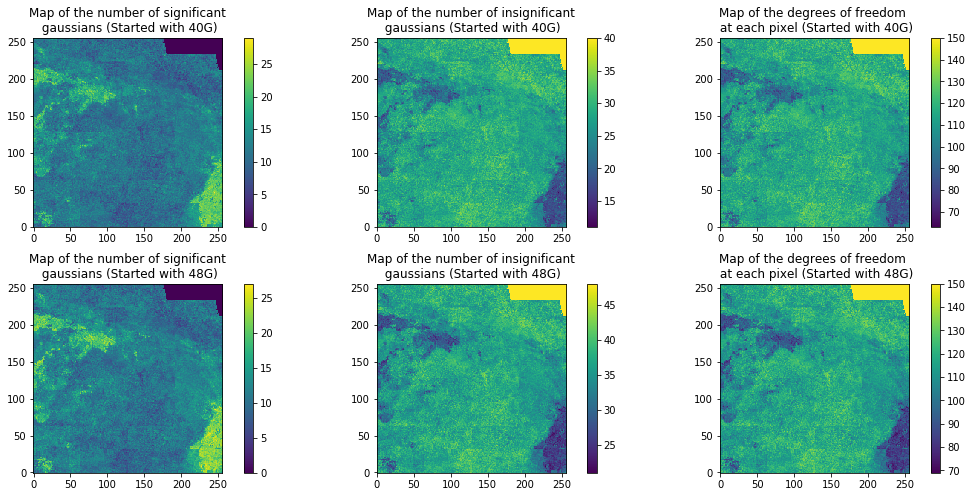

In [28]:
# Can plot a map of the number of free parameters at each pixel
fig = plt.figure(figsize=(20,8))

plt.subplot(2,3,1) ; plt.title("Map of the number of significant\n gaussians (Started with "+str(n_gauss_A)+"G)")
plt.imshow(signif_gauss_map_A, origin='lower') ; plt.colorbar()
plt.subplot(2,3,2) ; plt.title("Map of the number of insignificant\n gaussians (Started with "+str(n_gauss_A)+"G)")
plt.imshow(n_gauss_A - signif_gauss_map_A, origin='lower') ; plt.colorbar()
plt.subplot(2,3,3) ; plt.title("Map of the degrees of freedom \n at each pixel (Started with "+str(n_gauss_A)+"G)")
plt.imshow(degs_of_freedom_map_A, origin='lower') ; plt.colorbar()

plt.subplot(2,3,4) ; plt.title("Map of the number of significant\n gaussians (Started with "+str(n_gauss_B)+"G)")
plt.imshow(signif_gauss_map_B, origin='lower') ; plt.colorbar()
plt.subplot(2,3,5) ; plt.title("Map of the number of insignificant\n gaussians (Started with "+str(n_gauss_B)+"G)")
plt.imshow(n_gauss_B - signif_gauss_map_B, origin='lower') ; plt.colorbar()
plt.subplot(2,3,6) ; plt.title("Map of the degrees of freedom \n at each pixel (Started with "+str(n_gauss_B)+"G)")
plt.imshow(degs_of_freedom_map_B, origin='lower') ; plt.colorbar()

plt.subplots_adjust(wspace=-0.2, hspace=0.3)
#print("mean of significant gaussians = ", np.mean(signif_gauss_map_A))
#print("mean of zero gaussians = ", np.mean(n_gauss_A - signif_gauss_map_A))

### Calculate and Plot the Values of $\chi^{2}$ at each Pixel

In [29]:
noise_cube = cube[:24] # Using the first 24 channels of the index axis.
noise_map = np.std(noise_cube, 0)

rms = np.array([noise_map[:,:]*(1+channel/20) for channel in subcube]) # channel here means T_b

In [30]:
diff_A = (model_A - subcube) # model with 40 gaussians from ROHSA
chi_sq_map_A = np.sum((diff_A / rms)**2, 0)
red_chi_sq_map_A = chi_sq_map_A / degs_of_freedom_map_A
chi_sq_map_A[chi_sq_map_A != chi_sq_map_A] = 0
red_chi_sq_map_A[red_chi_sq_map_A != red_chi_sq_map_A] = 0

diff_B = (model_B - subcube) # model with 48 gaussians from ROHSA
chi_sq_map_B = np.sum((diff_B / rms)**2, 0)
red_chi_sq_map_B = chi_sq_map_B / degs_of_freedom_map_B
chi_sq_map_B[chi_sq_map_B != chi_sq_map_B] = 0
red_chi_sq_map_B[red_chi_sq_map_B != red_chi_sq_map_B] = 0

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


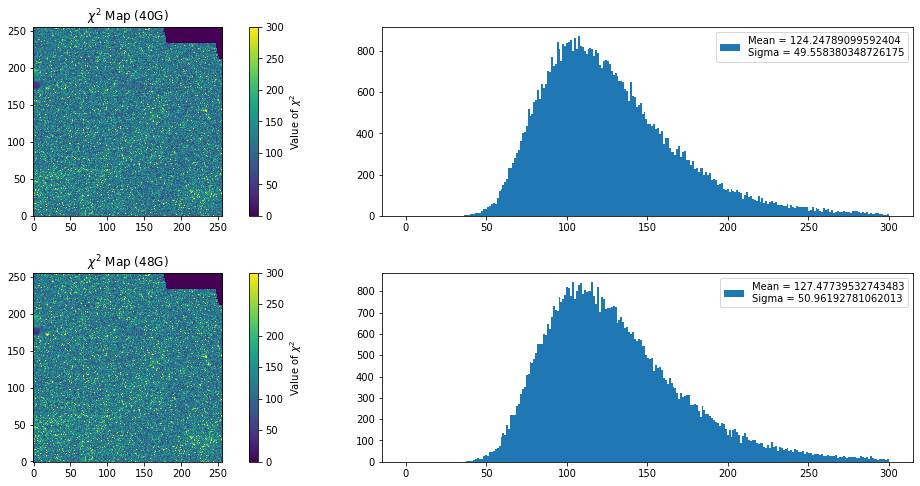

In [34]:
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.title("$\chi^{2}$ Map ("+str(n_gauss_A)+"G)")
plt.imshow(chi_sq_map_A, origin='lower', vmin=0, vmax=300.) ; plt.colorbar(label="Value of $\chi^{2}$")
plt.subplot(2,2,2)
y_chisq_map_A, x_chisq_map_A, _chisq_map_A = plt.hist(chi_sq_map_A.ravel(), bins=250, range=[1e-20,300.], label="Mean = "+str(np.mean(chi_sq_map_A))+"\nSigma = "+str(np.sqrt(np.var(chi_sq_map_A))))
plt.legend()
plt.subplot(2,2,3)
plt.title("$\chi^{2}$ Map ("+str(n_gauss_B)+"G)")
plt.imshow(chi_sq_map_B, origin='lower', vmin=0, vmax=300.) ; plt.colorbar(label="Value of $\chi^{2}$")
plt.subplot(2,2,4)
y_chisq_map_B, x_chisq_map_B, _chisq_map_B = plt.hist(chi_sq_map_B.ravel(), bins=250, range=[1e-20,300.], label="Mean = "+str(np.mean(chi_sq_map_B))+"\nSigma = "+str(np.sqrt(np.var(chi_sq_map_B))))
plt.legend()
plt.subplots_adjust(wspace=0.1, hspace=0.3)
#print(np.sqrt(2*free_params) / free_params)

Upon first look, the histograms look the same, however, I can plot them on top of each other to see how they differ.

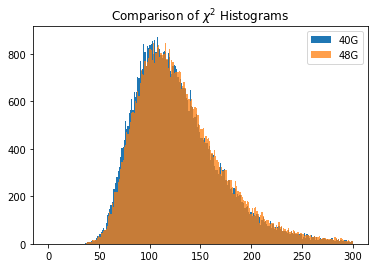

In [35]:
plt.title("Comparison of $\chi^{2}$ Histograms")
y_X2_map_A, x_X2_map_A, _X2_map_A = plt.hist(chi_sq_map_A.ravel(), bins=250, range=[1e-20,300.], label=str(n_gauss_A)+"G", alpha=1)
y_X2_map_B, x_X2_map_B, _X2_map_B = plt.hist(chi_sq_map_B.ravel(), bins=250, range=[1e-20,300.], label=str(n_gauss_B)+"G", alpha=0.75)
plt.legend()
plt.show()

Also interesting is the reduced $\chi^{2}$ maps and histograms.

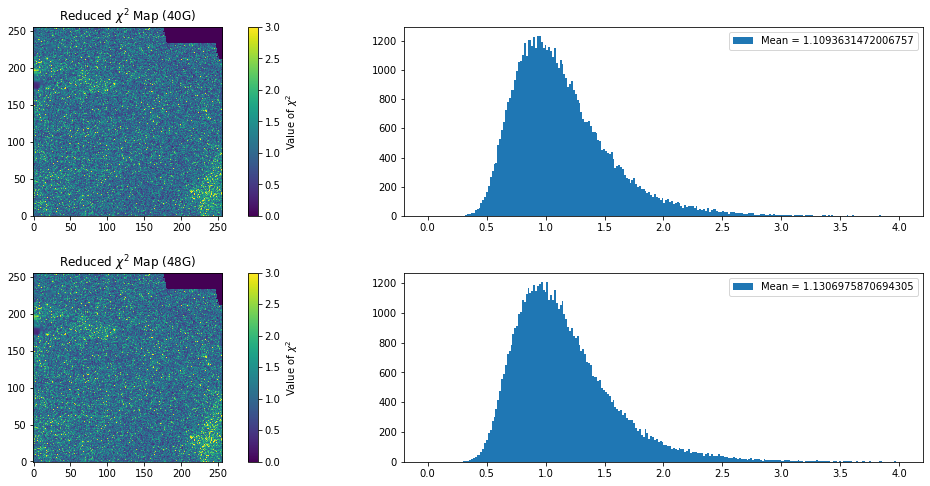

In [38]:
plt.figure(figsize=(20,8))
plt.subplot(2,2,1)
plt.title("Reduced $\chi^{2}$ Map ("+str(n_gauss_A)+"G)")
plt.imshow(red_chi_sq_map_A, origin='lower', vmin=0, vmax=3.) ; plt.colorbar(label="Value of $\chi^{2}$")
plt.subplot(2,2,2)
y_red_chisq_map_A, x_red_chisq_map_A, _red_chisq_map_A = plt.hist(red_chi_sq_map_A.ravel(), bins=250, range=[1e-20,4.], label="Mean = "+str(np.mean(red_chi_sq_map_A)))
plt.legend()
plt.subplot(2,2,3)
plt.title("Reduced $\chi^{2}$ Map ("+str(n_gauss_B)+"G)")
plt.imshow(red_chi_sq_map_B, origin='lower', vmin=0, vmax=3.) ; plt.colorbar(label="Value of $\chi^{2}$")
plt.subplot(2,2,4)
y_red_chisq_map_B, x_red_chisq_map_B, _red_chisq_map_B = plt.hist(red_chi_sq_map_B.ravel(), bins=250, range=[1e-20,4.], label="Mean = "+str(np.mean(red_chi_sq_map_B)))
plt.legend()
plt.subplots_adjust(wspace=0.15, hspace=0.3)

### Plot of the Spectrum with the highest value of $\chi^{2}$

For the 40G Chi Squared Map the spectrum with the highest chi squared is at the coordinates:
	x =  233
	y =  140
value of chi squared for this spectrum:  598.3152936392585 


For the 48G Chi Squared Map, the spectrum with the highest chi squared is at the coordinates:
	x =  233
	y =  140
value of chi squared for this spectrum:  776.496194590114


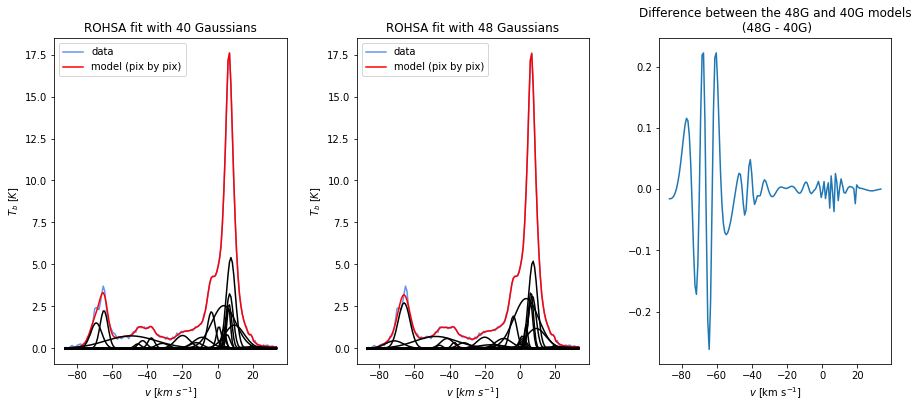

In [49]:
y_pos_high_chi2_A, x_pos_high_chi2_A = np.unravel_index(chi_sq_map_A.argmax(), chi_sq_map_A.shape)
y_pos_high_chi2_B, x_pos_high_chi2_B = np.unravel_index(chi_sq_map_B.argmax(), chi_sq_map_B.shape)

plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.title("ROHSA fit with "+str(n_gauss_A)+" Gaussians")
print("For the "+str(n_gauss_A)+"G Chi Squared Map the spectrum with the highest chi squared is at the coordinates:")
print("\tx = ", x_pos_high_chi2_A) ; print("\ty = ", y_pos_high_chi2_A)
plot_spect(n_gauss_A, x_pos_high_chi2_A, y_pos_high_chi2_A, subvel, model_A[:, y_pos_high_chi2_A,\
           x_pos_high_chi2_A],subcube[:, y_pos_high_chi2_A, x_pos_high_chi2_A], gaussian_A)
print("value of chi squared for this spectrum: ",chi_sq_map_A[y_pos_high_chi2_A][x_pos_high_chi2_A], "\n\n")

plt.subplot(1,3,2)
plt.title("ROHSA fit with "+str(n_gauss_B)+" Gaussians")
print("For the "+str(n_gauss_B)+"G Chi Squared Map, the spectrum with the highest chi squared is at the coordinates:")
print("\tx = ", x_pos_high_chi2_B) ; print("\ty = ", y_pos_high_chi2_B)
plot_spect(n_gauss_B, x_pos_high_chi2_B, y_pos_high_chi2_B, subvel, model_B[:, y_pos_high_chi2_B,\
           x_pos_high_chi2_B],subcube[:, y_pos_high_chi2_B, x_pos_high_chi2_B], gaussian_B)
print("value of chi squared for this spectrum: ",chi_sq_map_B[y_pos_high_chi2_B][x_pos_high_chi2_B])

plt.subplot(1,3,3)
plt.title("Difference between the "+str(n_gauss_B)+"G and "+str(n_gauss_A)+"G models\n (48G - 40G)")
plt.xlabel("$v$ [km s$^{-1}$]")
plt.plot(subvel, model_B[:, y_pos_high_chi2_B,x_pos_high_chi2_B]-model_A[:, y_pos_high_chi2_A,x_pos_high_chi2_A])
plt.subplots_adjust(wspace=0.3)

These spectra represent the pixel in the cube that has the highest $\chi^{2}$ value (for each model). They look almost exactly the same, but the difference spectra to the right shows where they differ, which is in the peak at about -65 km/s.

## Comparison of the $\chi^{2}$ Maps

The maps appear to be very similar. I can do a full comparison by dividing the map. The resulting map should be as flat as possible and have a value as close to 1 as possible.

In [50]:
quotient_chi_sq = chi_sq_map_B / chi_sq_map_A
quotient_red_chi_sq = red_chi_sq_map_B / red_chi_sq_map_A

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


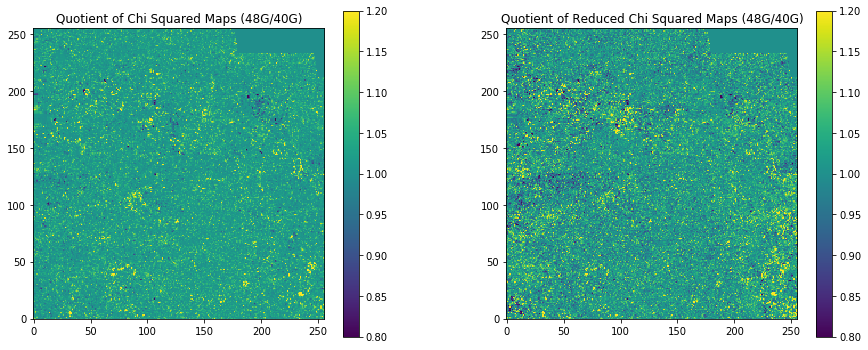

Mean of Chi Squared Quotient = 1.0257994936383346
Mean of Reduced Chi Squared Quotient = 1.0197720871068439


In [55]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("Quotient of Chi Squared Maps ("+str(n_gauss_B)+"G/"+str(n_gauss_A)+"G)")
quotient_chi_sq[quotient_chi_sq != quotient_chi_sq] = 1
plt.imshow(quotient_chi_sq, origin='lower',vmin=0.8, vmax=1.2) ; plt.colorbar()
plt.subplot(1,2,2)
plt.title("Quotient of Reduced Chi Squared Maps ("+str(n_gauss_B)+"G/"+str(n_gauss_A)+"G)")
quotient_red_chi_sq[quotient_red_chi_sq != quotient_red_chi_sq] = 1
plt.imshow(quotient_red_chi_sq, origin='lower', vmin=0.8 ,vmax=1.2) ; plt.colorbar()
plt.subplots_adjust(wspace=0.3)
plt.show()
print("Mean of Chi Squared Quotient =",np.mean(quotient_chi_sq))
print("Mean of Reduced Chi Squared Quotient =",np.mean(quotient_red_chi_sq))

From the left map, I can see that it is fairly flat. There are some spots of high or low quotients, but that is to be expected. The map is fairly flat and has values very close to 1, which shows that the chi squared map for both 40 and 48 Gaussian distributions are consitent with each other. We see that the mean of the $\chi^{2}$ quotient is close to 1 within 0.8%.

## Comparison of the models to the data

In the previous sections, I was comparing the $\chi^{2}$ values at each pixel. One thing that is important when looking at a model is how well it fits the data. I can create a map that shows the difference of the model and the data at each pixel (sum of model at pixel - sum of data at pixel). Ideally, this map should be close to zero and close to the noise, meaning that the difference is comparable to the noise and that the model is a good approximation to the data. Another way I can see how well the model fits the data is to take the quotient of model / data at each pixel. This should be close to 1.

In [56]:
# 40G
difference_map_A = np.zeros((subcube.shape[1], subcube.shape[2]))
quotient_map_A = np.zeros((subcube.shape[1], subcube.shape[2]))
for x in range(subcube.shape[1]):
    for y in range(subcube.shape[1]):
        difference_map_A[y,x] = np.sum(model_A[:,y,x] - subcube[:,y,x])*C*dv
        quotient_map_A[y,x] = (np.sum(model_A[:,y,x])) / (np.sum(subcube[:,y,x]))
quotient_map_A[quotient_map_A != quotient_map_A] = 1

# 48G
difference_map_B = np.zeros((subcube.shape[1], subcube.shape[2]))
quotient_map_B = np.zeros((subcube.shape[1], subcube.shape[2]))
for x in range(subcube.shape[1]):
    for y in range(subcube.shape[1]):
        difference_map_B[y,x] = np.sum(model_B[:,y,x] - subcube[:,y,x])*C*dv
        quotient_map_B[y,x] = (np.sum(model_B[:,y,x])) / (np.sum(subcube[:,y,x]))
quotient_map_B[quotient_map_B != quotient_map_B] = 1

/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/opt/python/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


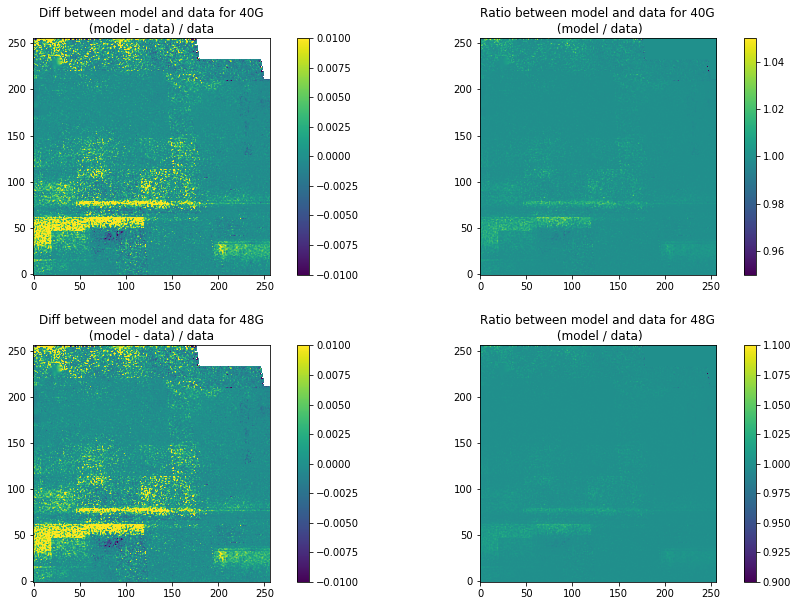

In [60]:
plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
plt.title("Diff between model and data for "+str(n_gauss_A)+"G\n (model - data) / data ")
plt.imshow(difference_map_A/(np.sum(subcube, 0)*C*dv), origin='lower', vmin=-0.01, vmax=0.01) ; plt.colorbar()
plt.subplot(2,2,2)
plt.title("Ratio between model and data for "+str(n_gauss_A)+"G\n (model / data)")
plt.imshow(quotient_map_A, origin='lower', vmin=0.95, vmax=1.05) ; plt.colorbar()
plt.subplot(2,2,3)
plt.title("Diff between model and data for "+str(n_gauss_B)+"G\n (model - data) / data ")
plt.imshow(difference_map_B/(np.sum(subcube, 0)*C*dv), origin='lower', vmin=-0.01, vmax=0.01) ; plt.colorbar()
plt.subplot(2,2,4)
plt.title("Ratio between model and data for "+str(n_gauss_B)+"G\n (model / data)")
plt.imshow(quotient_map_B, origin='lower', vmin=0.9, vmax=1.1) ; plt.colorbar()
plt.subplots_adjust(wspace=-0.2, hspace=0.3)

From these maps, for both cases (40G and 48G), the difference maps are very close to zero, which shows that the model is a good approximation to the data. On the other side, the quotient map shows a relatively flat map at 1. This is good because it also shows that the models are good approximations for the data. There are some areas on the left side near the bottom (around y = 50) in the same spots on all maps, where the difference is not quite 0, and where the quotient is not quite 1. Looking at the noise map above, these areas appear to have higher noise. Since the model does not quite fit the noise, the difference will fluctuate in these spots.